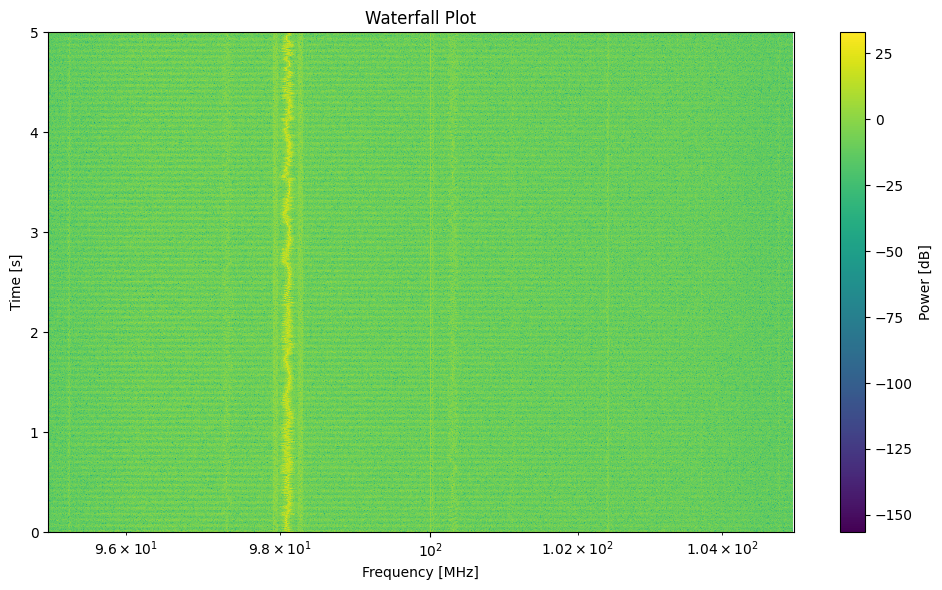

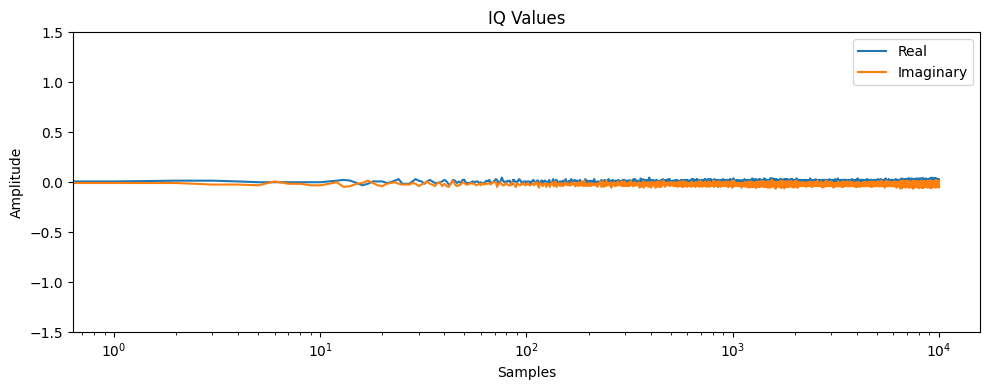

In [ ]:
from python_hackrf import pyhackrf  # type: ignore
import matplotlib.pyplot as plt
import numpy as np
import time
import sys

# Settings for the HackRF
recording_time = 5  # seconds
center_freq = 100e6  # Hz
sample_rate = 10e6
baseband_filter = 7.5e6
lna_gain = 16  # 0 to 40 dB in 8 dB steps
vga_gain = 20  # 0 to 62 dB in 2 dB steps

# Initialize HackRF
pyhackrf.pyhackrf_init()
sdr = pyhackrf.pyhackrf_open()

# Calculate the supported bandwidth relative to the desired one
allowed_baseband_filter = pyhackrf.pyhackrf_compute_baseband_filter_bw_round_down_lt(baseband_filter)

# Set up the HackRF parameters
sdr.pyhackrf_set_sample_rate(sample_rate)
sdr.pyhackrf_set_baseband_filter_bandwidth(allowed_baseband_filter)
sdr.pyhackrf_set_antenna_enable(True)
sdr.pyhackrf_set_freq(center_freq)
sdr.pyhackrf_set_amp_enable(False)
sdr.pyhackrf_set_lna_gain(lna_gain)
sdr.pyhackrf_set_vga_gain(vga_gain)

# Allocate buffer for samples
num_samples = int(recording_time * sample_rate)
samples = np.zeros(num_samples, dtype=np.complex64)
last_idx = 0

# Global flag to stop receiving samples
stop_receiving = False

# Callback function for receiving samples
def rx_callback(device, buffer, buffer_length, valid_length):
    global samples, last_idx, stop_receiving

    if stop_receiving:
        return 0

    try:
        accepted = valid_length // 2
        accepted_samples = np.frombuffer(buffer, dtype=np.int8, count=valid_length)
        accepted_samples = accepted_samples[0::2] + 1j * accepted_samples[1::2]  # Convert to complex type
        accepted_samples /= 128  # Normalize to -1 to +1

        if last_idx + accepted > len(samples):
            accepted = len(samples) - last_idx

        samples[last_idx: last_idx + accepted] = accepted_samples[:accepted]
        last_idx += accepted

    except Exception as e:
        print(f"Error in rx_callback: {e}")

    return 0

# Register the callback and start receiving
sdr.set_rx_callback(rx_callback)
sdr.pyhackrf_start_rx()

# Wait for recording to complete
try:
    time.sleep(recording_time) # hello
except KeyboardInterrupt:
    print("Recording interrupted by user")
finally:
    stop_receiving = True
    sdr.pyhackrf_stop_rx()
    sdr.pyhackrf_close()

# Ensure we have enough samples before processing
if last_idx < 100000:
    print("Not enough samples collected, skipping initial truncation")
    sys.exit(1)
else:
    samples = samples[100000:last_idx]  # Discard the first 100k samples to avoid transients

# Generate the spectrogram
fft_size = 2048
num_rows = len(samples) // fft_size

spectrogram = np.zeros((num_rows, fft_size))
for i in range(num_rows):
    segment = samples[i * fft_size:(i + 1) * fft_size]
    if len(segment) == fft_size:
        power_spectrum = np.abs(np.fft.fftshift(np.fft.fft(segment))) ** 2
        power_spectrum[power_spectrum == 0] = np.finfo(float).eps  # Avoid log of zero
        spectrogram[i, :] = 10 * np.log10(power_spectrum)

# Plot the waterfall diagram
extent = [(center_freq - sample_rate / 2) / 1e6, (center_freq + sample_rate / 2) / 1e6, 0, recording_time]

plt.figure(figsize=(10, 6))
plt.imshow(spectrogram, aspect='auto', extent=extent, origin='lower', cmap='viridis')
plt.xlabel("Frequency [MHz]")
plt.ylabel("Time [s]")
plt.title("Waterfall Plot")
plt.xscale("log")
plt.colorbar(label="Power [dB]")
plt.tight_layout()
import os
os.makedirs("images", exist_ok=True)
plt.savefig("images/waterfall_plot.png")

# Plot the real and imaginary parts of the collected samples
plt.figure(figsize=(10, 4))
plt.plot(np.real(samples[:10000]), label="Real")
plt.plot(np.imag(samples[:10000]), label="Imaginary")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.xscale("log")
plt.title("IQ Values")
plt.ylim([-1.5, 1.5])
plt.tight_layout()
os.makedirs("images", exist_ok=True)
plt.savefig("images/iq_values_plot.png")

plt.show()

# a test
# will this make the move?